In [71]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

### Analyze Data

In [72]:
train_data=pd.read_csv('fraudTest.csv')

In [73]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [74]:
train_data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,555718.000000,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [75]:
train_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

### Processing Data

In [76]:
#Tranform to datetime to can read data as strings

train_data['trans_date_trans_time']=pd.to_datetime(train_data['trans_date_trans_time'])

train_data["dob"]=pd.to_datetime(train_data["dob"])

In [77]:
#Clean Data from unusseful columns

train_data.drop(columns=['Unnamed: 0','cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num','trans_date_trans_time'],inplace=True)
train_data

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,fraud_Kirlin and Sons,personal_care,2.86,M,33.9659,-80.9355,333497,Mechanical engineer,1371816865,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,personal_care,29.84,F,40.3207,-110.4360,302,"Sales professional, IT",1371816873,39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,40.6729,-73.5365,34496,"Librarian, public",1371816893,40.495810,-74.196111,0
3,fraud_Haley Group,misc_pos,60.05,M,28.5697,-80.8191,54767,Set designer,1371816915,28.812398,-80.883061,0
4,fraud_Johnston-Casper,travel,3.19,M,44.2529,-85.0170,1126,Furniture designer,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...
555714,fraud_Reilly and Sons,health_fitness,43.77,M,40.4931,-91.8912,519,Town planner,1388534347,39.946837,-91.333331,0
555715,fraud_Hoppe-Parisian,kids_pets,111.84,M,29.0393,-95.4401,28739,Futures trader,1388534349,29.661049,-96.186633,0
555716,fraud_Rau-Robel,kids_pets,86.88,F,46.1966,-118.9017,3684,Musician,1388534355,46.658340,-119.715054,0
555717,fraud_Breitenberg LLC,travel,7.99,M,44.6255,-116.4493,129,Cartographer,1388534364,44.470525,-117.080888,0


In [78]:
missing_values = train_data.isnull().sum()
print(missing_values)

merchant      0
category      0
amt           0
gender        0
lat           0
long          0
city_pop      0
job           0
unix_time     0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64


In [79]:
fraud_counts=train_data['is_fraud'].value_counts()
print(fraud_counts)

is_fraud
0    553574
1      2145
Name: count, dtype: int64


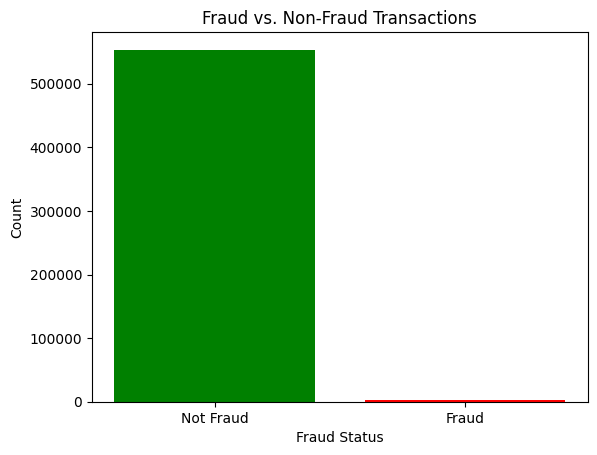

In [80]:
colors = ['green' if val == 0 else 'red' for val in fraud_counts.index]

# Plot the bar chart
plt.bar(fraud_counts.index, fraud_counts.values, color=colors)

# Customize the chart
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])  # Set labels for the x-axis
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()

### Balancing the data

In [81]:
#Tranform important data to numeric values
encoder = LabelEncoder()
categorical_columns = ['merchant', 'category', 'gender', 'job']
for col in categorical_columns:
    train_data[col] = encoder.fit_transform(train_data[col])

In [82]:
#Devide data 
X = train_data.drop(columns=['is_fraud'])
y = train_data['is_fraud']

In [83]:
#Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [84]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=42,stratify=y)

In [85]:
def evaluate_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    # Evaluation for different arhitecture models(Regresion,XGBOOST,Decision Tree)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_prob is not None:
        auc_score = roc_auc_score(y_test, y_prob)
        print(f"AUC-ROC Score: {auc_score:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

## Logistic Regression


Evaluating Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    166072
           1       0.05      0.77      0.09       644

    accuracy                           0.94    166716
   macro avg       0.52      0.85      0.53    166716
weighted avg       1.00      0.94      0.97    166716

AUC-ROC Score: 0.8678


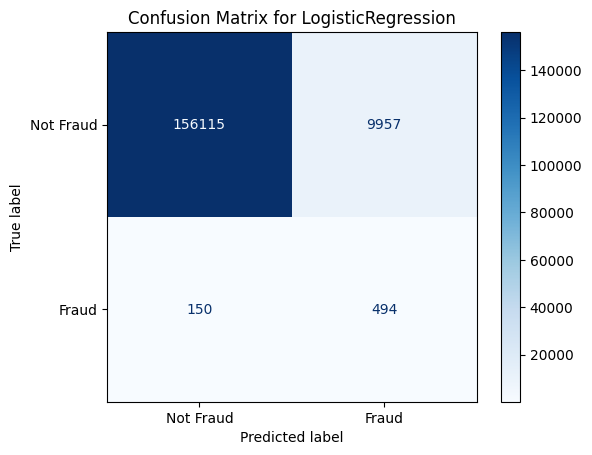

In [86]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
print("\nEvaluating Logistic Regression...")
evaluate_model(log_reg, X_train, y_train, X_test, y_test)

## Decision Tree 


Evaluating Decision Tree...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    166072
           1       0.09      0.88      0.16       644

    accuracy                           0.96    166716
   macro avg       0.54      0.92      0.57    166716
weighted avg       1.00      0.96      0.98    166716

AUC-ROC Score: 0.9713


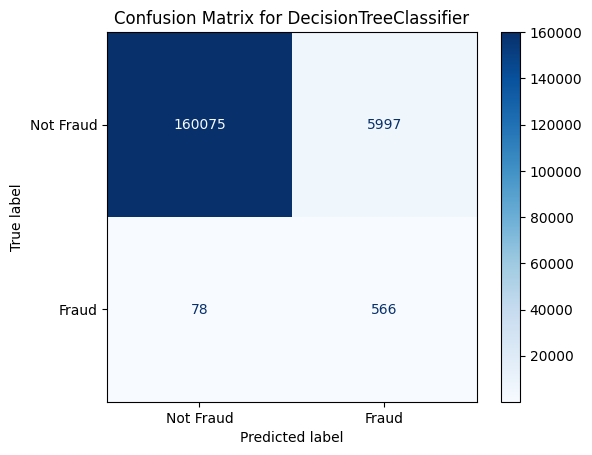

In [87]:
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
print("\nEvaluating Decision Tree...")
evaluate_model(decision_tree, X_train, y_train, X_test, y_test)

## XGBoost


Evaluating XGBoost...


d:\Machine_Learning\Project_Sigmoid\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.93      0.77      0.84       644

    accuracy                           1.00    166716
   macro avg       0.96      0.88      0.92    166716
weighted avg       1.00      1.00      1.00    166716

AUC-ROC Score: 0.9989


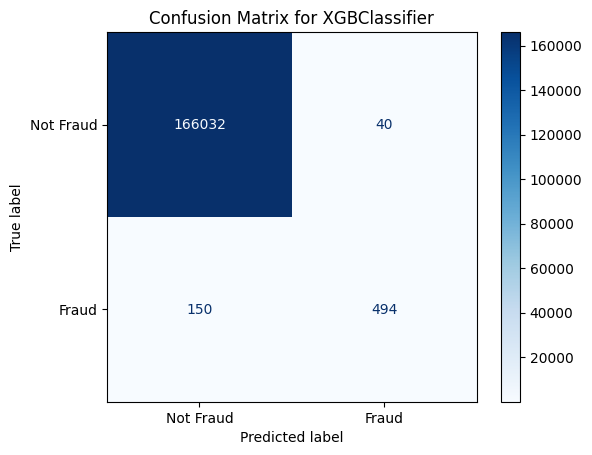

In [88]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print("\nEvaluating XGBoost...")
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)